In [ ]:
MODEL = "resnet34"  # enter model name
N_EPOCHS = 16  # enter number of epochs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.testset import get_imagedataset2025_test_set
from microrobot_dl.data_loader import get_dataloaders
from microrobot_dl.model import get_model
from tqdm import tqdm
import os
import json

torch.manual_seed(60648)

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif (
    getattr(torch.backends, "mps", None) is not None
    and torch.backends.mps.is_available()
    and torch.backends.mps.is_built()
):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
# Define Transforms
# ResNet expects 224x224 input.
# The dataset loads images as grayscale ("L").
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

# Load Dataset
dataset = ImageDataset2025(
    base_dir="../data/2025_Dataset", mode="pose", multi_label=False, transform=transform
)

num_classes = len(dataset.idx_to_label)
print(f"Total samples: {len(dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {dataset.idx_to_label}")

Total samples: 2002
Number of classes: 40
Classes: ['P0_R0', 'P10_R0', 'P15_R0', 'P15_R15', 'P15_R30', 'P15_R45', 'P15_R5', 'P25_R0', 'P30_R0', 'P30_R10', 'P30_R15', 'P30_R30', 'P30_R45', 'P30_R5', 'P30_R60', 'P35_R0', 'P40_R0', 'P45_R0', 'P45_R10', 'P45_R15', 'P45_R30', 'P45_R45', 'P45_R5', 'P45_R60', 'P50_R0', 'P55_R0', 'P5_R0', 'P60_R0', 'P60_R10', 'P60_R15', 'P60_R30', 'P60_R45', 'P60_R5', 'P60_R60', 'P65_R0', 'P70_R0', 'P75_R0', 'P80_R0', 'P85_R0', 'P90_R0']


In [4]:
test_set_info = get_imagedataset2025_test_set()
test_indices = test_set_info["test_indices"]
test_indices = list(test_indices)
test_set = set(test_indices)

test_len = len(test_indices)
train_val_len = len(dataset) - test_len

all_indices = list(range(len(dataset)))
train_val_indices = [i for i in all_indices if i not in test_set]

test_dataset = torch.utils.data.Subset(dataset, test_indices)
train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)

train_loader, test_loader, val_loader = get_dataloaders(
    train_val_dataset,
    test_dataset,
    val_ratio=0.1,
    train_batch_size=32,
    test_batch_size=64,
    val_batch_size=64,
)


In [5]:
# Setup Model
model = get_model(MODEL)

# Modify the first convolutional layer to accept 1 channel (grayscale) instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
MODEL_NAME = f"{MODEL}_pose_model_single_label"
MODEL_PATH = f"../model/{MODEL_NAME}.pth"
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float("inf")

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
                "val_loss": val_loss,
            },
            MODEL_PATH,
        )
        print(f"Saved best model to {MODEL_PATH} (Val Loss: {val_loss:.4f})")

    print(
        f"Epoch {epoch + 1}/{N_EPOCHS} - Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
    )

100%|██████████| 51/51 [00:18<00:00,  2.78it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 3.9969)
Epoch 1/32 - Train Loss: 3.6523 Acc: 0.0820 | Val Loss: 3.9969 Acc: 0.0667


100%|██████████| 51/51 [00:18<00:00,  2.77it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 2.5232)
Epoch 2/32 - Train Loss: 2.6169 Acc: 0.2176 | Val Loss: 2.5232 Acc: 0.2667


100%|██████████| 51/51 [00:17<00:00,  2.84it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 2.1213)
Epoch 3/32 - Train Loss: 1.8026 Acc: 0.3853 | Val Loss: 2.1213 Acc: 0.3444


100%|██████████| 51/51 [00:17<00:00,  2.90it/s]



Epoch 4/32 - Train Loss: 1.3483 Acc: 0.5376 | Val Loss: 2.2899 Acc: 0.3444


100%|██████████| 51/51 [00:17<00:00,  2.88it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 1.8185)
Epoch 5/32 - Train Loss: 1.0268 Acc: 0.6430 | Val Loss: 1.8185 Acc: 0.4944


100%|██████████| 51/51 [00:17<00:00,  2.90it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 1.2290)
Epoch 6/32 - Train Loss: 0.8304 Acc: 0.7176 | Val Loss: 1.2290 Acc: 0.5833


100%|██████████| 51/51 [00:17<00:00,  2.86it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 1.0691)
Epoch 7/32 - Train Loss: 0.6517 Acc: 0.7707 | Val Loss: 1.0691 Acc: 0.6722


100%|██████████| 51/51 [00:17<00:00,  2.86it/s]



Epoch 8/32 - Train Loss: 0.4972 Acc: 0.8212 | Val Loss: 1.2695 Acc: 0.6389


100%|██████████| 51/51 [00:17<00:00,  2.90it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.6329)
Epoch 9/32 - Train Loss: 0.4580 Acc: 0.8416 | Val Loss: 0.6329 Acc: 0.7667


100%|██████████| 51/51 [00:18<00:00,  2.81it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.5760)
Epoch 10/32 - Train Loss: 0.3964 Acc: 0.8576 | Val Loss: 0.5760 Acc: 0.8222


100%|██████████| 51/51 [00:18<00:00,  2.82it/s]



Epoch 11/32 - Train Loss: 0.2846 Acc: 0.9032 | Val Loss: 0.6217 Acc: 0.8111


100%|██████████| 51/51 [00:17<00:00,  2.87it/s]



Epoch 12/32 - Train Loss: 0.3099 Acc: 0.8915 | Val Loss: 0.9886 Acc: 0.7278


100%|██████████| 51/51 [00:17<00:00,  2.85it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.4649)
Epoch 13/32 - Train Loss: 0.2852 Acc: 0.9032 | Val Loss: 0.4649 Acc: 0.8444


100%|██████████| 51/51 [00:18<00:00,  2.83it/s]



Epoch 14/32 - Train Loss: 0.1963 Acc: 0.9316 | Val Loss: 0.4757 Acc: 0.8278


100%|██████████| 51/51 [00:17<00:00,  2.87it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.4006)
Epoch 15/32 - Train Loss: 0.1843 Acc: 0.9359 | Val Loss: 0.4006 Acc: 0.8722


100%|██████████| 51/51 [00:17<00:00,  2.85it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.3436)
Epoch 16/32 - Train Loss: 0.1618 Acc: 0.9531 | Val Loss: 0.3436 Acc: 0.8833


100%|██████████| 51/51 [00:17<00:00,  2.84it/s]



Epoch 17/32 - Train Loss: 0.1127 Acc: 0.9605 | Val Loss: 0.7975 Acc: 0.7889


100%|██████████| 51/51 [00:17<00:00,  2.84it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.2390)
Epoch 18/32 - Train Loss: 0.1014 Acc: 0.9698 | Val Loss: 0.2390 Acc: 0.9167


100%|██████████| 51/51 [00:18<00:00,  2.83it/s]



Epoch 19/32 - Train Loss: 0.0855 Acc: 0.9766 | Val Loss: 0.2967 Acc: 0.9167


100%|██████████| 51/51 [00:18<00:00,  2.82it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.2367)
Epoch 20/32 - Train Loss: 0.0602 Acc: 0.9815 | Val Loss: 0.2367 Acc: 0.9389


100%|██████████| 51/51 [00:18<00:00,  2.83it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.1854)
Epoch 21/32 - Train Loss: 0.0332 Acc: 0.9908 | Val Loss: 0.1854 Acc: 0.9444


100%|██████████| 51/51 [00:17<00:00,  2.85it/s]



Epoch 22/32 - Train Loss: 0.0615 Acc: 0.9803 | Val Loss: 0.3664 Acc: 0.8667


100%|██████████| 51/51 [00:18<00:00,  2.83it/s]



Epoch 23/32 - Train Loss: 0.1009 Acc: 0.9741 | Val Loss: 0.2529 Acc: 0.9167


100%|██████████| 51/51 [00:17<00:00,  2.87it/s]



Epoch 24/32 - Train Loss: 0.1485 Acc: 0.9544 | Val Loss: 1.0263 Acc: 0.7611


100%|██████████| 51/51 [00:17<00:00,  2.88it/s]



Epoch 25/32 - Train Loss: 0.2668 Acc: 0.9125 | Val Loss: 0.7480 Acc: 0.8389


100%|██████████| 51/51 [00:18<00:00,  2.83it/s]



Epoch 26/32 - Train Loss: 0.2695 Acc: 0.9118 | Val Loss: 0.5463 Acc: 0.8611


100%|██████████| 51/51 [00:18<00:00,  2.73it/s]



Epoch 27/32 - Train Loss: 0.1005 Acc: 0.9661 | Val Loss: 0.3225 Acc: 0.9167


100%|██████████| 51/51 [00:18<00:00,  2.78it/s]



Epoch 28/32 - Train Loss: 0.0893 Acc: 0.9741 | Val Loss: 0.4391 Acc: 0.8889


100%|██████████| 51/51 [00:17<00:00,  2.89it/s]



Epoch 29/32 - Train Loss: 0.0458 Acc: 0.9834 | Val Loss: 0.3413 Acc: 0.8889


100%|██████████| 51/51 [00:17<00:00,  2.84it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.1790)
Epoch 30/32 - Train Loss: 0.0618 Acc: 0.9858 | Val Loss: 0.1790 Acc: 0.9556


100%|██████████| 51/51 [00:17<00:00,  2.86it/s]



Epoch 31/32 - Train Loss: 0.0218 Acc: 0.9920 | Val Loss: 0.1824 Acc: 0.9556


100%|██████████| 51/51 [00:17<00:00,  2.91it/s]



Saved best model to ../model/resnet50_pose_model_single_label.pth (Val Loss: 0.1453)
Epoch 32/32 - Train Loss: 0.0063 Acc: 0.9988 | Val Loss: 0.1453 Acc: 0.9556


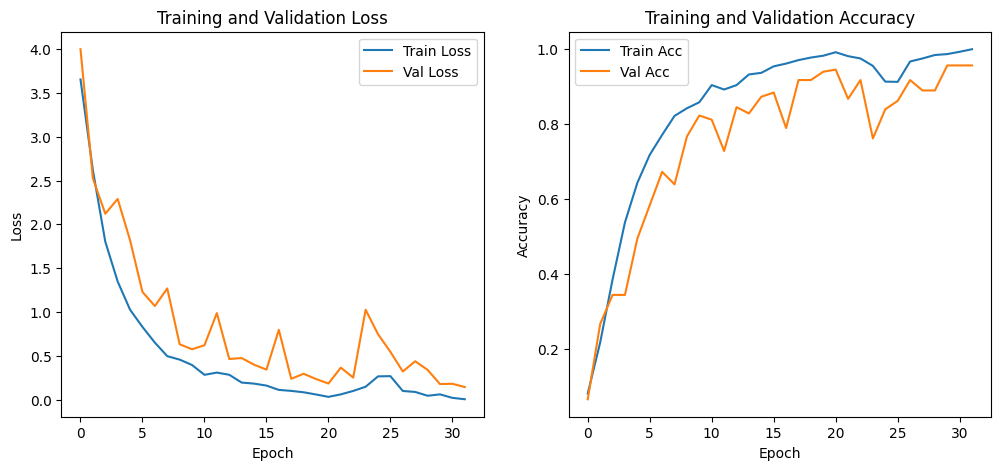

In [7]:
# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

In [8]:
# Test Evaluation
# Load best checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
if "optimizer_state_dict" in checkpoint:
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

epoch_loaded = checkpoint.get("epoch")
val_acc_loaded = checkpoint.get("val_acc")
val_loss_loaded = checkpoint.get("val_loss")
print(
    f"Loaded checkpoint from {MODEL_PATH} (epoch={epoch_loaded}, val_acc={val_acc_loaded}, val_loss={val_loss_loaded})"
)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Loaded checkpoint from ../model/resnet50_pose_model_single_label.pth (epoch=32, val_acc=0.9555555555555556, val_loss=0.1452948831849628)
Test Set Accuracy: 0.9600
Test Set Accuracy: 0.9600


In [9]:
results = {
    "model_name": MODEL_NAME,
    "accuracy": test_accuracy,
}

out_path = os.path.join(".eval", f"{MODEL_NAME}.json")
with open(out_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved results to {out_path}")

Saved results to .eval/resnet50_pose_model_single_label.json
